# Generative Adversarial Networks

Generative adversarial networks (GANs) are, as the name suggests, generative networks. This typically implies that they use a random distribution to generate "fake" data rather than regressing or classifying real data. Ultimately, this process is essentially the same - the model learns a distribution of data and takes in a predictor and outputs a regressor. GANs have been an incredibly popular (relatively) recent development in Deep Learning with the seminal paper being introduced by [Goodfellow et. al. (2016)](https://arxiv.org/abs/1406.2661). 

They are typically used for tasks such as image infilling, style transfer, and image upscaling: all visually attentive tasks. However, they are a general statistical process and they have found practical applications in the life sciences e.g. batch equalisation. They are also typically constructed with neural networks but the key insight will generalise to *any* functions that admit a probability distribution.


## Generators and Discriminators

A GAN is thought of as a single model but it is composed of two indepedent models that are trained concurrently: a generator and a discriminator. The generator does exactly what it implies taking some random input and generating a data-like object e.g. an image, a voice file etc. The discriminator conversely takes a data-like object from either the generator or a real dataset and outputs a boolean: was the data real, or fake? Typically, the generator is denoted with $G$, discriminator $D$, fake input seeds $z$, and data $x$.

$$ G(z) = x^\prime $$
$$ D(x) = b \in \{\text{true}, \text{false}\}$$

The pair of functions define the GAN completely. They are frequently convolutional nets, recurrent nets, and gated recurrent nets. They are also frequently dense feed-forward nets, but these come with the same performance penalties that we discussed in previous notebooks. The goal, as always, is to train the parameters of the model to achieve a particular objective which, in the case of GANs, is to get the generator to "trick" the discriminator.

## Loss Functions

The loss function of a GAN is given by:

$$ L = -\mathbb{E}_{x \in \text{data}} \left[\log(D(x))\right] - \mathbb{E}_{z \in \text{generation}} \left[\log(1 - D(G(z))\right] $$

which is known as the $\min-\max$ loss function and is nothing more than the cross entropy loss function asscociated with a binary variable. In practice we will often see this this decomposed into two loss functions: one for the generator and one for the discriminator. This is because the generator does not depend on the first term and the gradient will be therefore zero and the discriminator doesn't know which distribution each data point originated from.

## Training

As always, a loss function may be optimised in whichever way the user sees fit. The traditional method of training a GAN is done in three stages. First, a batch is presented to the generator which trains itself to perform well against the discriminator and the generator weights are updated. Second, a batch of fake data is passed to the discriminator which trains itself to pick up the generator and discriminator weights are accordingly updated. Third, to stop the discriminator always choosing "fake" as its output a batch of real data is passed to the discriminator and the discriminator weights are updated. The generator and discriminator weights are never updated in the same step.

Since the discriminator tries to assign a "0" to each fake datum and the generator tries to assign a "1" the two training functions act in contrast to each other. They are adversarial in nature and this is the complete origin on the name.

### Batching
To easily batch between real and fake data we can apply a trick of multiplying the loss components by their expected classification value. This makes the loss agnostic to the generator source (distributions are a generating process). The discrimator loss for an individual data point which is real or fake is simply:

$$ L(y, x) = -y \log(D(x)) - (1 - y)\log(1 - D(x)) $$.
### Tracking
In addition to tracking the generator and discriminator loss it is common to track the *accuracy* of the discriminator. This is nothing more than the proportion of a sample of real and fake data that it correctly classifies.

### Optimisers
GANs are often trained with vanilla SGD or SGD with momentum. Another reasonably common optimiser is RMSProp potentially due to its use in the original paper. Finally, ADAM is often employed due to its general popularity as an optimiser.

### Convergence
GANs are difficult to train. They rely on a trade-off between two loss functions that are at odds with each other and can therefore be inherently unstable. In addition to tracking the loss we track the accuracy and it is generally by monitoring these things and also by monitoring the ouput of the GAN that we decide when it is sufficiently converged. The basic rule is to train until the loss functions have roughly stablised at a sensible loss and when the accuracy of the discriminator stablises at approximately 1/2. We will explore this in the next section.

In practice, we will need to apply several regularisation techniques such as dropout, early stopping, gradient clipping and so forth. We also will tend to play with hyper-parameters and optimisers. In general, it is a bit of a push-pull process of toying with the data and the architecture. 

There are a couple of quite common problems to watch out with GANs: mode collapse and gradient vanishing. Gradient vanishing occurs usually when the loss function becomes very small forcing the gradient size to also be small. Often, this can be spotted when the discriminator loss tends to zero and the generator loss increases. This can be accompanied by the accuracy of the discriminator tending to 100\%. Instablities can also manifest in exploding gradaients and these can be controlled in the normal fashion. 

Mode collapse is a slightly more subtle problem - it refers to the generator converging on a small portion of the data domain. It means that the model produces quite high quality examples of data with a low variance. This is most often seen with a generator generating a single high quality image. It can be trained to fool the discriminator in the normal way, yet it is not representative of the full data. It can often be spotted when the generator loss and discriminator loss osscilate against each other; be careful here because they often go in opposite directions. It can also be identified by simply inspecting the output data. Usually, data inspection works best on visual images - we have a remarkably sophisticated visual processing system. Mode collapse can be tamed, often, by increasing the dimension of the latent space in which $z$ is sampled from.

## Two-player games

The common metaphor (and analysis technique) for understanding GANs is through a two player game. The players in the game in are the discriminator and the generator. The objective of the discriminator is to "catch" the generator and pick between false and real data. The objective of the generator is to fool the discriminator. 

The steady state of a two-player game is called the Nash equilibrium. The Nash eqilibrium of a well trained GAN is when the discriminator gets it right 50\% of the time i.e. it is no better than just flipping a coin.  When this happens the GAN has essentially meet its objective.

### Mathematical Theory
By inserting the definition for the genearator probability into the loss function applying the chain rule and integrating over the domain we find that the optimal discrinimator must be:

$$ D^*(x) = \frac{p_\text{data}(x)}{p_G(x) + p_\text{data}(x)} $$

This reduces the problem to optimising only over the generator - something that perhaps was already obvious. We can now decompose the objective into an expression of the sum of Kullback-Leibler divergences in the generator and data probability distributions.

$$ L[G] = \mathbb{E}_{x\sim p_\text{data}}\left[\log\left(\frac{p_\text{data}(x)}{p_G(x) + p_\text{data}(x)}\right) \right] +  \mathbb{E}_{x\sim p_G} \left[\log \left(\frac{p_G(x)}{p_G(x) + p_\text{data}(x)} \right)\right] $$

$$ L[G] = D_\text{KL}\left(p_\text{data} \Vert \frac{1}{2}(p_\text{data} + p_G) \right) + D_\text{KL}\left(p_\text{G} \Vert \frac{1}{2}(p_\text{data} + p_G) \right)$$

Finally, we borrow a fact from mathematics: the Kullback-Leibler divergence is never negative and is zero if and only the two distributions are equal. For these divergences the global minimum therefore must be $p_\text{data} = p_G$. We can conclude that game we are playing has a global minima at the point where the generator can perfectly mimic the data distribution. This is a powerful result.

### Theory in action

Let's test this theory out by training a simple GAN on a complicated probability distribution. We will choose a mixture of Gaussian variables. This seems quite simple at first but observing the PDF of the distribution may convince you that this sample presented without context is fairly non-trivial. We will set up a GAN to take a singleton latent variable $z$ and output a sample of a given dimension. We will let the network train naively.

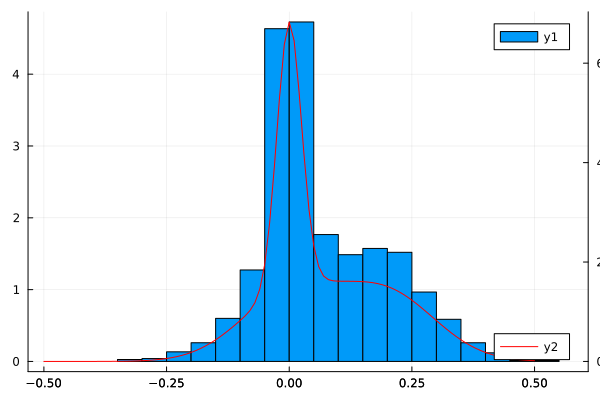

In [1]:
using Distributions, Plots, Flux
d = MixtureModel(Normal[Normal(0.0, 0.025), Normal(0.2, 0.1), Normal(0.0, 0.1)])
data = rand(d, 3000)
plot(data; st=:histogram, legend=:topright, normed=true)
plot!(twinx(),-0.5:0.01:0.5, Distributions.pdf.(d, -0.5:0.01:0.5), c=:red, legend=:bottomright)

In [2]:
# Define the model architectures and loss
D(samples) = Chain(Dense(samples=>100, relu), Dense(100=>50, relu), Dense(50=>1, σ))
G(input, samples) = Chain(Dense(input=>50, relu), Dense(50=>1000, relu), Dense(1000=>samples, x->0.5*tanh(x), bias=false))
lossD(x, y, dsc) = -Flux.mean(y .* log.(dsc(x))) .- Flux.mean((1 .- y) .* log.(1 .- dsc(x)))
lossG(z, gen, dsc) = -Flux.mean(log.(dsc(gen(z))))

# Training functions
function train_discriminator(dsc, gen, input, samp, batch, opt, distribution, distsamples)
    # we need some real and fake data
    gendata = gen(sort!(rand(inp, samp), dims=1))
    realdata = sort!(rand(distribution, distsamples, samp), dims=1)

    # lets batch and shuffle the data around for an epoch
    d1 = cat(gendata, realdata, dims=2)
    d2 = hcat(zeros(1, size(gendata)[end]), ones(1, size(realdata)[end]))
    data = Flux.DataLoader((d1, d2), batchsize=batch, shuffle=true);
    # training
    L = 0
    for i in data
        g = gradient(()->lossD(i..., dsc), Flux.params(dsc))
        Flux.update!(opt, Flux.params(dsc), g)
        L += lossD(i..., dsc)
    end    
    return L
end

function train_generator(gen, dsc, input, samp, batch, opt, distribution, distsamples)
    # we need some real and fake data
    gendata = sort!(rand(inp, samp), dims=1)
    data = Flux.DataLoader(gendata, batchsize=batch, shuffle=true);
    # training
    L = 0
    for i in data
        gs = gradient(()-> lossG(i, gen, dsc), Flux.params(gen))
        Flux.update!(opt, Flux.params(gen), gs)
        L += lossG(i, gen, dsc)
    end
    return L
end

# Convenience Training Functions
function accuracy(samp, inp, gen, dsc, distribution, distsamples)
    gendata = gen(sort!(rand(inp, samp), dims=1))
    realdata = sort!(rand(distribution, distsamples, samp), dims=1) 
    d1 = cat(gendata, realdata, dims=2)
    d2 = hcat(zeros(1, size(gendata)[end]), ones(1, size(realdata)[end]))
    v1 = (dsc(gendata) .< 0.5) .== 0
    v2 = (dsc(realdata) .> 0.5) .== 1
    return sum(v1) / length(v1), sum(v2) / length(v2)
end

function acculumate_loss(ld, lg, acr, acf, LG, LD, ac)
    append!(ld, LD)
    append!(lg, LG)
    append!(acf, ac[1])
    append!(acr, ac[2])
    return nothing
end

acculumate_loss (generic function with 1 method)

In [3]:
epochs = 1000;
distsamples = 3000;
batch = 1;
inp = 5;
trainingsamples = 1;
opt = RMSProp(0.0001);
gen = G(inp, distsamples);
dsc = D(distsamples);
ld = [0.0]; lg = [0.0]; acr = [0.0]; acf = [0.0];

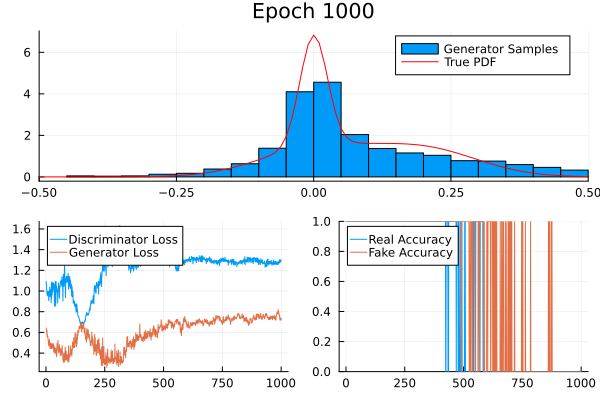

In [4]:
for e in 1:epochs
    LD = train_discriminator(dsc, gen, inp, trainingsamples, batch, opt, data, distsamples)
    LG = train_generator(gen, dsc, inp, trainingsamples, batch, opt, data, distsamples)
    ac = accuracy(trainingsamples, inp, gen, dsc, data, distsamples)
    acculumate_loss(ld, lg, acr, acf, LG, LD, ac)

    # tracking
    if mod(e, 5)== 0
        generator_sample = gen(rand(inp, 1))
        plt = plot(vec(generator_sample); st=:histogram, xlim=(-0.5, 0.5), legend=:topright, norm=true, label="Generator Samples", title="Epoch $(e)")
        plot!(plt, -0.5:0.01:0.5, Distributions.pdf.(d, -0.5:0.01:0.5), c=:red, label="True PDF")
        #plt = plot(generator_sample[:])
        
        plt_loss = plot(1:e, ld[2:end], label="Discriminator Loss", legend=:topleft)
        plot!(plt_loss, 1:e, lg[2:end], label="Generator Loss")
        
        plt_ac = plot(1:e, acr[2:end], label="Real Accuracy", ylim=(0,1), legend=:topleft)
        plot!(plt_ac, 1:e, acf[2:end], label="Fake Accuracy", ylim=(0,1), legend=:topleft)

        l = @layout[a; b{0.5w} c{0.5w}]
        display(plot(plt, plt_loss, plt_ac, layout=l))
        IJulia.clear_output(true)
    end
end

## Generating Arbitrary Distributions.

The above example demonstrates that GANs very effectively learn probability distributions. This particular example could easily have been achieved by kernel denisty estimation or even an empirical distribution fit. These techniques are inappropriate for high dimensional data such as images. Furthermore, we can exploit all of the techniques we have already learned for using appropriate network structures on given data types.

The advantages this approach brings are phenomenal: we now have a way to learn the probability distribution of a data generating process. This allows us to generate data cheaply and synthesize new instances: generating faces that don't exist is a very popular example. It also allows us to understand the distribution. We can train and validate physical models using the data far more effectively. We can also model process noise and control for things such as inter-data variance from measurement technqiues.

In [27]:
using MLDatasets
mnist = MLDatasets.MNIST.traindata()
training_data = reshape(mnist[1], (28,28,1,60000));
training_labels = mnist[2];

In [106]:
discriminator = Chain(
    Conv((4,4), 1=>64, stride=(2,2), pad=SamePad(), leakyrelu),
    Dropout(0.2),
    Conv((4,4), 64=>64, stride=(2,2), pad=SamePad(), leakyrelu),
    Dropout(0.2),
    Flux.flatten,
    Dense(3136=>1, σ)
)

generator = Chain(
    Dense(latent_dim=>prod([7,7,128,1])), 
    x->reshape(x, 7,7,128,1), 
    Conv((4,4), 128=>128, stride=(2,2), pad=(12, 12), leakyrelu),
    Dropout(0.2),
    Conv((4,4), 128=>128, stride=(2,2), pad=(22, 22), leakyrelu),
    Dropout(0.2),
    Conv((7,7), 128=>1, pad=SamePad(), tanh)
)

1×1 Matrix{Float64}:
 0.4998468292368388

In [108]:
latent_dim = 100
epochs = 1
device=cpu
training(training_data, latent_dim, epochs, generator, discriminator, Momentum(), Momentum(); logepoch=1)

LoadError: UndefVarError: colouring not defined

### A simple visual example

Let's try and build our own useful GAN model. We can import a dataset of blood cell slides containing white and red blood cells as well as plasma. The labellings are not important for us at the moment. The dataset can be found at [Shengans GitHub](https://github.com/Shenggan/BCCD_Dataset/tree/master/BCCD). Let's import these and convert them into tensors of floats.

1-element Vector{Matrix{RGB{N0f8}}}:
 [RGB{N0f8}(0.643,0.565,0.541) RGB{N0f8}(0.675,0.592,0.612) … RGB{N0f8}(0.737,0.682,0.682) RGB{N0f8}(0.718,0.647,0.631); RGB{N0f8}(0.651,0.565,0.549) RGB{N0f8}(0.667,0.576,0.596) … RGB{N0f8}(0.729,0.643,0.686) RGB{N0f8}(0.745,0.671,0.635); … ; RGB{N0f8}(0.694,0.596,0.588) RGB{N0f8}(0.682,0.596,0.627) … RGB{N0f8}(0.718,0.659,0.78) RGB{N0f8}(0.792,0.812,0.792); RGB{N0f8}(0.725,0.706,0.671) RGB{N0f8}(0.788,0.792,0.737) … RGB{N0f8}(0.718,0.616,0.757) RGB{N0f8}(0.855,0.824,0.875)]
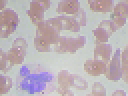

In [5]:
using Images, FileIO, CUDA
datadirls = readdir("./data/cells"); # find the file names
data_images = [imresize(Images.load("./data/cells/" * i), (48,64)) for i in datadirls[2:2]]
#data_images = data_images[1:25]
data = cat([Float32.(permutedims(channelview(x), [3,2,1])) for x in data_images]...,dims=4);
display(data_images)

Now we have a tensor of floats where the third dimension represents the RGB channel. This has been concatenated to include the fourth dimension as the data ID and the dimension which would be aggregated along in a loss function. We now need to define our generator and discriminator models. We know the data size in this case so we wont define special instantiation functions but rather work with them directly.

In [6]:
device = gpu
latent_dim = 10
discriminator = Chain(
    Conv((5,5), 3 => 5, relu),
    MaxPool((4,4)),
    Conv((2,2), 5=>7, relu),
    MaxPool((2,2)),
    Conv((3,3), 7=>2, relu),
    Flux.flatten,
    Dense(30=>1, σ)
) |> device

generator = Chain(
    Dense(latent_dim=>prod([72,56,1,1])), 
    x->reshape(x, 72,56,1,1), 
    Conv((3,3), 1=>7, relu), 
    Conv((2,2), 7=>4, relu), 
    Conv((6,6), 4=>3, relu)
) |> device

LoadError: CUDA error: invalid argument (code 1, ERROR_INVALID_VALUE)

Let's now check that the generator produces an image. It will likely be mostly black at this stage but hopefully that will improve during learning. We will also define a convenience function to perform this conversion so that we can check it during the training.

In [497]:
colouring(tens) = colorview(RGB, permutedims(tens[:,:,:,1], [3,2,1]))
colouring(generator(rand(Float32, latent_dim)|> device)|>cpu)

We now need to define our training functions as well as accuracy and logging. We will train our GAN using 1 sample per batch for each of the generator, and discriminator training steps. We will choose a very simple training schedule using default hyper-parameters for a momentum based descent. Notice that we have not chosen any regularisation layers such as dropout in our model definition. We shall train for approximately 400 epochs

In [36]:
using ProgressMeter

function train_gen(latent_dim, gen, dsc, opt)
    latent_sample = rand(Float32,latent_dim) |> device
    gs = gradient(()-> lossG(latent_sample, gen, dsc), Flux.params(gen))
    Flux.update!(opt, Flux.params(gen), gs)
    return nothing
end

function train_dsc(data, latent_dim, gen, dsc, opt)
    fake_data = gen(rand(Float32,latent_dim) |> device)
    gs = gradient(()->lossD(fake_data, 0f0, dsc), Flux.params(dsc))
    Flux.update!(opt, Flux.params(dsc), gs)
    ridx = rand(1:size(data)[end])
    real_data = data[:,:,:,ridx:ridx] |> device
    gs = gradient(()->lossD(real_data, 1f0, dsc), Flux.params(dsc))
    Flux.update!(opt, Flux.params(dsc), gs)
    return nothing
end

function tracking(acr, acf, lg, ld, data, dsc, gen, latent_dimension)
    #latent_samples = [rand(Float32, latent_dim) |> device for i in 1:size(data)[end]]
    LG = 0; LD = 0; AR = 0; AF = 0;
    L = size(data)[end]
    for i in 1:minimum([L,10])
        latent = rand(Float32, latent_dim) |> device
        fake_data = gen(latent)
        rdxi = rand(1:L)
        real_data = data[:,:,:,rdxi:rdxi] |> device
        LG += lossG(latent, gen, dsc) |> cpu
        LD += lossD(real_data, 1f0, dsc) + lossD(fake_data, 0f0, dsc) |> cpu
        AR += (dsc(real_data)|> cpu .> 0.5)[1] * 1.0 
        AF += (dsc(fake_data)|> cpu .< 0.5)[1] * 1.0
    end
    append!(lg,LG)
    append!(ld,LD)
    append!(acr, AR/size(data)[end])
    append!(acf, AF/size(data)[end])
    return nothing
end

function plotting(epoch, acr, acf, lg, ld, gen, latent_dimension)
    plt1 = plot(1:length(lg), [lg ld]; title="Epoch $(epoch): Loss", label=["Generator" "Discriminator"], legend=:bottomleft)
    plt2 = plot(1:length(acr), [acr acf]; title="Accuracy", label=["Real Data" "Fake Data"], legend=:bottomleft)
    displot = plot(plt1, plt2, layout=(2,1))
   # vissample = 
    img1 = colouring(gen(rand(Float32, latent_dimension)|> device) |> cpu)
    img2 = colouring(gen(rand(Float32, latent_dimension)|> device) |> cpu)
    img3 = colouring(gen(rand(Float32, latent_dimension)|> device) |> cpu)

    display(displot)
    display([colouring(gen(rand(Float32, latent_dimension)|> device) |> cpu) for i in 1:5])
    return nothing
end

function training(data, latent_dim, epochs, gen, dsc, gen_opt, dsc_opt; logging=true, logepoch=5)
    acr = []; acf = []; lg = []; ld = [];
    for e in 1:epochs
       # p = Progress(size(data)[end], 1, "Epoch $(e)", 10)
        for i in 1:size(data)[end]
            train_gen(latent_dim, gen, dsc, gen_opt)
            train_dsc(data, latent_dim, gen, dsc, dsc_opt)
          #  next!(p)
        end
        if (e % logepoch == 0) && logging
            #println(lg)
            tracking(acr, acf, lg, ld, data, dsc, gen, latent_dim)
            plotting(e, acr, acf, lg, ld, gen, latent_dim)
            IJulia.clear_output(true)
        end
    end
end

training (generic function with 1 method)

What we have observed is an example of saturation or vanishing gradients. Our discriminator is actually too good for the network to train on and as a result is ouputting the same loss (the correct loss) each time. This makes it difficult to compute a realistic gradient. Let's reduce the complexity of the discriminator model and try again. 

Now we appear to have solved the vanshing gradients problem but notice that the output sample image is almost always identical. This is an example of mode collapse. We can make our generator more complex and give it access to more dimensions in the latent space. The idea behind this is that it will learn a more partitioned representation of the latent space and because it has more degrees of freedom it wont get trapped in a particular subset.

That appears to have solved it. Now the GAN is training well, the gradients are not vanishing, and it is outputing representative images. This is quite remarkable; our model has learnt to output images that for all intents and purposes visually represent what comes directly from a wet lab bench.

In [499]:
device = gpu
latent_dim = 10

discriminator = Chain(
    Conv((2,2), 3 => 5, tanh),
    Conv((3,3), 5 => 4, tanh),
    Conv((3,3), 4 => 2, tanh),
    MaxPool((3,3)),
    Flux.flatten,
    Dense(532=>1, σ)
) |> device

generator = Chain(
    Dense(latent_dim=>latent_dim, tanh, bias=false), 
    x->reshape(x, 70,54,3,1), 
    Conv((5,5), 3=>10, tanh), 
    Conv((3,3), 10=>3, σ)
) |> device

epochs = 2500
opt_gen = Nesterov()
opt_dsc = Nesterov()
training(data, latent_dim, epochs, generator, discriminator, opt_gen, opt_dsc; logepoch=1)

In [ ]:
device = gpu
latent_dim = 10

discriminator = Chain(
    Conv((4,4), 1=>64, stride=(2,2), pad=SamePad(), leakyrelu),
    Dropout(0.2),
    Conv((4,4), 64=>64, stride=(2,2), pad=SamePad(), leakyrelu),
    Dropout(0.2),
    Flux.flatten,
    Dense(3136=>1, σ)
) |> device

generator = Chain(
    Dense(latent_dim=>prod([7,7,128,1])), 
    x->reshape(x, 7,7,128,1), 
    Conv((4,4), 128=>128, stride=(2,2), pad=(12, 12), leakyrelu),
    Dropout(0.2),
    Conv((4,4), 128=>128, stride=(2,2), pad=(22, 22), leakyrelu),
    Dropout(0.2),
    Conv((7,7), 128=>1, pad=SamePad(), tanh)
) |> device

epochs = 2500
opt_gen = Nesterov()
opt_dsc = Nesterov()
training(data, latent_dim, epochs, generator, discriminator, opt_gen, opt_dsc; logepoch=1)